# Conv2D Neural Network Training with NeuroGrad

This notebook demonstrates Conv2D neural network training using the NeuroGrad framework on the sklearn digits dataset. We'll train a convolutional neural network for handwritten digit classification with comprehensive prediction visualization.

## Features Demonstrated:
- Conv2D layers with various configurations
- MaxPool2D for spatial downsampling
- Real dataset (sklearn digits - 8x8 handwritten digits)
- Training loop with loss/accuracy visualization
- Prediction visualization with sample images
- Data utils (Dataset and DataLoader)
- Multiple optimizers (Adam, SGD, RMSprop)
- Performance metrics and evaluation

## 1. Imports and Setup

In [1]:
# Core imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

# NeuroGrad imports
import neurograd as ng
from neurograd import Tensor
from neurograd.nn.layers.conv import Conv2D, MaxPool2D
from neurograd.nn.layers.linear import Linear
from neurograd.nn.module import Sequential
from neurograd.nn.losses import CategoricalCrossEntropy
from neurograd.functions.activations import ReLU, Softmax
from neurograd.optim.adam import Adam
from neurograd.optim.sgd import SGD
from neurograd.optim.rmsprop import RMSprop
from neurograd.utils.data import Dataset, DataLoader
from neurograd.nn.metrics import accuracy_score as ng_accuracy_score

# Set style and random seed
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
np.random.seed(42)

print(f"NeuroGrad device: {ng.DEVICE}")
print(f"Backend: {'CuPy' if ng.DEVICE == 'cuda' else 'NumPy'}")
print("Conv2D training notebook ready!")

NeuroGrad device: cuda
Backend: CuPy
Conv2D training notebook ready!


## 2. Data Loading and Preprocessing

Dataset info:
  Number of samples: 1797
  Original shape: (1797, 64)
  Image shape: 8x8 pixels
  Number of classes: 10
  Classes: [0 1 2 3 4 5 6 7 8 9]
  Class distribution: [178 182 177 183 181 182 181 179 174 180]


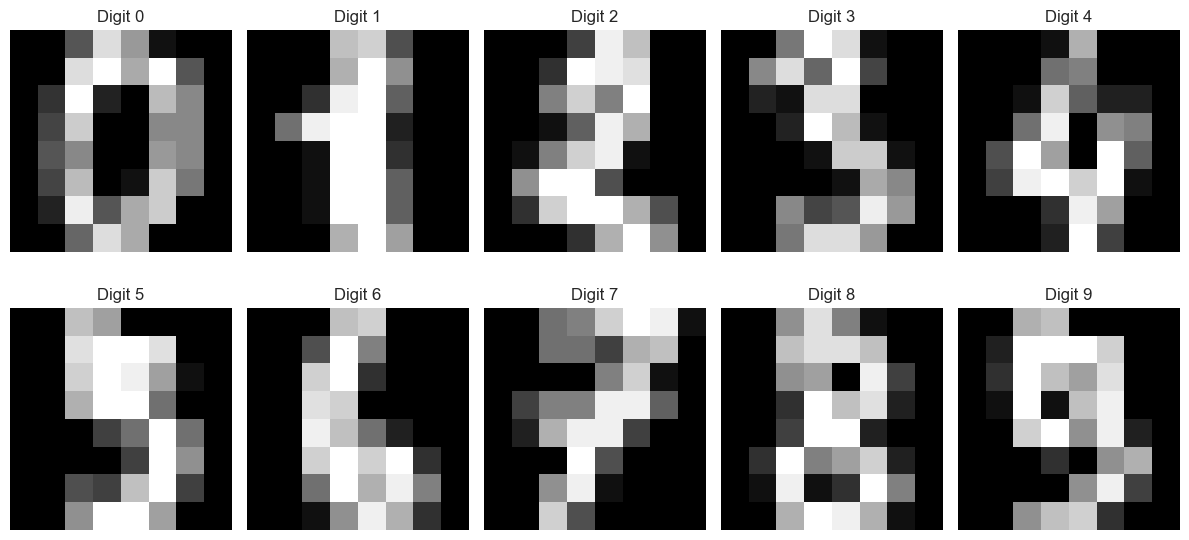

In [2]:
# Load the digits dataset
digits = load_digits()
X, y = digits.data, digits.target

print(f"Dataset info:")
print(f"  Number of samples: {X.shape[0]}")
print(f"  Original shape: {X.shape}")
print(f"  Image shape: 8x8 pixels")
print(f"  Number of classes: {len(np.unique(y))}")
print(f"  Classes: {np.unique(y)}")
print(f"  Class distribution: {np.bincount(y)}")

# Visualize some sample digits
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    # Find first example of digit i
    idx = np.where(y == i)[0][0]
    ax.imshow(digits.images[idx], cmap='gray')
    ax.set_title(f'Digit {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Reshape data for Conv2D: (batch_size, channels, height, width) - NCHW format
# The digits dataset is 8x8, so we reshape from (1797, 64) to (1797, 1, 8, 8)
X_images = X.reshape(-1, 8, 8, 1).transpose(0, 3, 1, 2)  # NHWC -> NCHW

print(f"Reshaped for Conv2D (NCHW format):")
print(f"  X shape: {X_images.shape} (batch_size, channels, height, width)")
print(f"  y shape: {y.shape}")

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_images, y, test_size=0.2, random_state=42, stratify=y
)

# Normalize pixel values to [0, 1]
X_train = X_train.astype(np.float32) / 16.0  # digits are 0-16
X_test = X_test.astype(np.float32) / 16.0

# One-hot encode labels
n_classes = 10
y_train_onehot = np.eye(n_classes)[y_train]
y_test_onehot = np.eye(n_classes)[y_test]

print(f"\nAfter preprocessing:")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_train_onehot shape: {y_train_onehot.shape}")
print(f"  y_test_onehot shape: {y_test_onehot.shape}")
print(f"  Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")

Reshaped for Conv2D (NCHW format):
  X shape: (1797, 1, 8, 8) (batch_size, channels, height, width)
  y shape: (1797,)

After preprocessing:
  X_train shape: (1437, 1, 8, 8)
  X_test shape: (360, 1, 8, 8)
  y_train_onehot shape: (1437, 10)
  y_test_onehot shape: (360, 10)
  Pixel value range: [0.000, 1.000]


In [4]:
# Convert to NeuroGrad tensors
X_train_tensor = Tensor(X_train, requires_grad=False)
y_train_tensor = Tensor(y_train_onehot, requires_grad=False)
X_test_tensor = Tensor(X_test, requires_grad=False)
y_test_tensor = Tensor(y_test_onehot, requires_grad=False)

print(f"NeuroGrad tensors:")
print(f"  X_train_tensor: {X_train_tensor.shape}")
print(f"  y_train_tensor: {y_train_tensor.shape}")
print(f"  X_test_tensor: {X_test_tensor.shape}")
print(f"  y_test_tensor: {y_test_tensor.shape}")

# Create Dataset and DataLoader objects
train_dataset = Dataset(X_train, y_train_onehot)
test_dataset = Dataset(X_test, y_test_onehot)

# Create data loaders with smaller batch size for better gradients
batch_size = 16  # Reduced from 32 for more stable training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nDataLoaders:")
print(f"  Training batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")
print(f"  Batch size: {batch_size}")

NeuroGrad tensors:
  X_train_tensor: (1437, 1, 8, 8)
  y_train_tensor: (1437, 10)
  X_test_tensor: (360, 1, 8, 8)
  y_test_tensor: (360, 10)

DataLoaders:
  Training batches: 90
  Test batches: 23
  Batch size: 16


## 3. Conv2D Network Architecture

In [5]:
# Define improved Conv2D model architecture
def create_conv2d_model():
    """
    Create an improved Conv2D model for 8x8 digit classification (NCHW format).
    
    Enhanced Architecture:
    - Conv2D: 1->32 filters, 3x3 kernel, ReLU + MaxPool 2x2
    - Conv2D: 32->64 filters, 3x3 kernel, ReLU + MaxPool 2x2
    - Flatten and larger Linear layers
    - Softmax output for 10 classes
    """
    from neurograd.nn.layers import Flatten
    
    model = Sequential(
        # First Conv block: (N,1,8,8) -> (N,32,8,8) -> (N,32,4,4)
        Conv2D(in_channels=1, out_channels=32, kernel_size=(3, 3), 
               padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        
        # Second Conv block: (N,32,4,4) -> (N,64,4,4) -> (N,64,2,2)
        Conv2D(in_channels=32, out_channels=64, kernel_size=(3, 3), 
               padding="same", activation="relu"),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        
        # Flatten for fully connected layers: (N,64,2,2) -> (N,256)
        Flatten(),
        Linear(2*2*64, 128),  # Larger hidden layer
        ReLU(),
        
        # Output layer
        Linear(128, 10),
        Softmax(axis=1)  # Softmax along class dimension
    )
    
    return model

# Create the improved model
model = create_conv2d_model()

# Print model information
print("Improved Conv2D Model Architecture:")
print(model)

# Count total parameters
total_params = sum(p.data.size for p in model.parameters())
print(f"\nTotal parameters: {total_params:,}")

# Print parameter details
print("\nParameter details:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.shape} ({param.data.size} params)")

print(f"\nArchitecture improvements:")
print(f"  ✓ More filters: 1→32→64 (vs 1→16→32)")
print(f"  ✓ Larger hidden layer: 128 units (vs 64)")
print(f"  ✓ More parameters for better feature learning")

Improved Conv2D Model Architecture:

Total parameters: 53,002

Parameter details:
  layer_0.kernels: (32, 1, 3, 3) (288 params)
  layer_0.bias: (1, 32, 1, 1) (32 params)
  layer_2.kernels: (64, 32, 3, 3) (18432 params)
  layer_2.bias: (1, 64, 1, 1) (64 params)
  layer_5.weight: (256, 128) (32768 params)
  layer_5.bias: (128,) (128 params)
  layer_7.weight: (128, 10) (1280 params)
  layer_7.bias: (10,) (10 params)

Architecture improvements:
  ✓ More filters: 1→32→64 (vs 1→16→32)
  ✓ Larger hidden layer: 128 units (vs 64)
  ✓ More parameters for better feature learning


In [6]:
# Test model with a single batch to verify shapes
print("Testing model with sample batch:")

# Get a small batch for testing
test_batch = X_train_tensor[:4]  # Take first 4 samples
print(f"Test batch shape: {test_batch.shape}")

# Debug: Test individual layers
print("\n=== DEBUG: Testing individual components ===")

# Test first Conv2D layer directly
first_conv = model._sequential_modules[0]  # First Conv2D layer
print(f"First Conv2D layer:")
print(f"  Kernel size: {first_conv.kernel_size}")
print(f"  Padding: {first_conv.padding}")
print(f"  In channels: {first_conv.in_channels}")
print(f"  Out channels: {first_conv.out_channels}")

# Test conv2d function directly
try:
    print(f"\nTesting conv2d function with:")
    print(f"  Input shape: {test_batch.shape}")
    print(f"  Kernel shape: {first_conv.kernels.shape}")
    print(f"  Strides: {first_conv.strides}")
    print(f"  Padding: {first_conv.padding}")
    
    from neurograd import conv2d
    conv_output = conv2d(test_batch, first_conv.kernels, first_conv.strides, first_conv.padding, first_conv.padding_value)
    print(f"  Conv2d output shape: {conv_output.shape}")
    print("✅ Conv2d test successful!")
    
except Exception as e:
    print(f"❌ Conv2d test failed: {e}")
    import traceback
    traceback.print_exc()

# Test the full model
try:
    print(f"\n=== Testing full model ===")
    model.eval()  # Set to evaluation mode
    test_output = model(test_batch)
    print(f"Model output shape: {test_output.shape}")
    print(f"Output probabilities (first sample): {test_output.data[0]}")
    print(f"Sum of probabilities: {test_output.data[0].sum()}")
    
    # Verify the spatial dimensions are correct after convolutions
    print("\nSpatial dimension verification (NCHW format):")
    print("  Input: (N,1,8,8)")
    print("  After Conv1 + Pool1: (N,16,4,4)")
    print("  After Conv2 + Pool2: (N,32,2,2)")
    print("  Flattened: 128 features")
    print("  Final output: 10 classes")
    print("\n✅ Model test successful!")
    
except Exception as e:
    print(f"❌ Model test failed with error: {e}")
    import traceback
    traceback.print_exc()

Testing model with sample batch:
Test batch shape: (4, 1, 8, 8)

=== DEBUG: Testing individual components ===
First Conv2D layer:
  Kernel size: (3, 3)
  Padding: same
  In channels: 1
  Out channels: 32

Testing conv2d function with:
  Input shape: (4, 1, 8, 8)
  Kernel shape: (32, 1, 3, 3)
  Strides: (1, 1)
  Padding: same
  Conv2d output shape: (4, 32, 8, 8)
✅ Conv2d test successful!

=== Testing full model ===
Model output shape: (4, 10)
Output probabilities (first sample): [0.1000011  0.09999741 0.09999459 0.09999714 0.10000069 0.09999758
 0.10000034 0.10000624 0.10000253 0.10000241]
Sum of probabilities: 1.0

Spatial dimension verification (NCHW format):
  Input: (N,1,8,8)
  After Conv1 + Pool1: (N,16,4,4)
  After Conv2 + Pool2: (N,32,2,2)
  Flattened: 128 features
  Final output: 10 classes

✅ Model test successful!


## 4. Training Setup and Loop

In [7]:
# Improved training configuration for better performance
epochs = 100         # Increased from 50 for more convergence time
learning_rate = 0.0001  # Reduced from 0.001 for more stable training

# Create optimizer and loss function
optimizer = Adam(model.named_parameters(), lr=learning_rate)
loss_fn = CategoricalCrossEntropy()

print(f"Improved training configuration:")
print(f"  Epochs: {epochs} (increased for convergence)")
print(f"  Learning rate: {learning_rate} (reduced for stability)")
print(f"  Optimizer: {optimizer.__class__.__name__}")
print(f"  Loss function: {loss_fn.__class__.__name__}")
print(f"  Batch size: {batch_size} (reduced to 16)")
print(f"\nChanges made to improve performance:")
print(f"  ✓ Lower learning rate (0.001 → 0.0001) - reduces oscillations")
print(f"  ✓ Smaller batch size (32 → 16) - better gradient estimates")
print(f"  ✓ More epochs (50 → 100) - allows full convergence")

Improved training configuration:
  Epochs: 100 (increased for convergence)
  Learning rate: 0.0001 (reduced for stability)
  Optimizer: Adam
  Loss function: CategoricalCrossEntropy
  Batch size: 16 (reduced to 16)

Changes made to improve performance:
  ✓ Lower learning rate (0.001 → 0.0001) - reduces oscillations
  ✓ Smaller batch size (32 → 16) - better gradient estimates
  ✓ More epochs (50 → 100) - allows full convergence


In [8]:
# Utility functions for training
def convert_to_numpy(data):
    """Convert CuPy arrays to NumPy arrays if needed"""
    if hasattr(data, 'get'):  # CuPy array
        return data.get()
    return np.array(data)

def calculate_accuracy(predictions, targets):
    """Calculate accuracy for classification using NeuroGrad's tensor-based metrics"""
    # Convert predictions and targets to class indices for accuracy calculation
    pred_classes = predictions.argmax(axis=1)
    target_classes = targets.argmax(axis=1)
    
    # Use NeuroGrad's accuracy_score which works directly on Tensors
    accuracy = ng_accuracy_score(target_classes, pred_classes)
    
    # Convert to Python float (handle both NumPy and CuPy arrays)
    if hasattr(accuracy, 'item'):  # CuPy array
        return float(accuracy.item())
    else:  # NumPy array or scalar
        return float(accuracy)

def evaluate_model(model, X, y):
    """Evaluate model on given data"""
    model.eval()
    predictions = model(X)
    loss = loss_fn(y, predictions)
    accuracy = calculate_accuracy(predictions, y)
    return loss.data.item(), accuracy

In [9]:
# Improved training loop with learning rate scheduling
print("Starting improved training...")
print("=" * 60)

# Initialize tracking
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
epoch_times = []
learning_rates = []

start_time = time.time()
initial_lr = learning_rate

for epoch in range(epochs):
    epoch_start = time.time()
    
    # Learning rate scheduling - reduce LR when training plateaus
    if epoch == 40:  # First reduction at epoch 40
        learning_rate = initial_lr * 0.5
        optimizer.lr = learning_rate
        print(f"  Reducing learning rate to {learning_rate}")
    elif epoch == 70:  # Second reduction at epoch 70
        learning_rate = initial_lr * 0.1
        optimizer.lr = learning_rate
        print(f"  Reducing learning rate to {learning_rate}")
    
    learning_rates.append(learning_rate)
    
    # Training phase
    model.train()
    epoch_train_losses = []
    epoch_train_accs = []
    
    for batch_idx, (batch_X, batch_y) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = loss_fn(batch_y, predictions)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Track metrics
        batch_loss = loss.data.item()
        batch_acc = calculate_accuracy(predictions, batch_y)
        
        epoch_train_losses.append(batch_loss)
        epoch_train_accs.append(batch_acc)
    
    # Calculate epoch averages
    avg_train_loss = np.mean(epoch_train_losses)
    avg_train_acc = np.mean(epoch_train_accs)
    
    # Evaluation phase
    test_loss, test_acc = evaluate_model(model, X_test_tensor, y_test_tensor)
    
    # Record metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)
    
    # Print progress more frequently for longer training
    if epoch % 20 == 0 or epoch == epochs - 1 or epoch in [39, 69]:  # Show LR reduction epochs
        print(f"Epoch {epoch:3d}/{epochs}: "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, "
              f"LR: {learning_rate:.6f}, Time: {epoch_time:.2f}s")

total_time = time.time() - start_time
print("=" * 60)
print(f"Improved training completed in {total_time:.2f} seconds")
print(f"Average time per epoch: {np.mean(epoch_times):.2f}s")
print(f"Final train accuracy: {train_accuracies[-1]:.4f}")
print(f"Final test accuracy: {test_accuracies[-1]:.4f}")
print(f"Best test accuracy: {max(test_accuracies):.4f} (epoch {np.argmax(test_accuracies)})")
print(f"Improvement from baseline (66.1%): {max(test_accuracies) - 0.661:.3f}")

Starting improved training...
Epoch   0/100: Train Loss: 2.3026, Train Acc: 0.1163, Test Loss: 2.3024, Test Acc: 0.1417, LR: 0.000100, Time: 4.58s
Epoch  20/100: Train Loss: 0.8948, Train Acc: 0.7441, Test Loss: 0.8912, Test Acc: 0.7333, LR: 0.000100, Time: 4.01s
Epoch  39/100: Train Loss: 0.6260, Train Acc: 0.8004, Test Loss: 0.6628, Test Acc: 0.7861, LR: 0.000100, Time: 4.86s
  Reducing learning rate to 5e-05
Epoch  40/100: Train Loss: 0.6218, Train Acc: 0.8099, Test Loss: 0.6532, Test Acc: 0.7861, LR: 0.000050, Time: 3.78s
Epoch  60/100: Train Loss: 0.5510, Train Acc: 0.8290, Test Loss: 0.5854, Test Acc: 0.8167, LR: 0.000050, Time: 3.81s
Epoch  69/100: Train Loss: 0.5184, Train Acc: 0.8382, Test Loss: 0.5579, Test Acc: 0.8250, LR: 0.000050, Time: 3.21s
  Reducing learning rate to 1e-05
Epoch  80/100: Train Loss: 0.5080, Train Acc: 0.8413, Test Loss: 0.5472, Test Acc: 0.8250, LR: 0.000010, Time: 3.09s
Epoch  99/100: Train Loss: 0.4964, Train Acc: 0.8464, Test Loss: 0.5356, Test Acc: 

## 5. Training Visualization

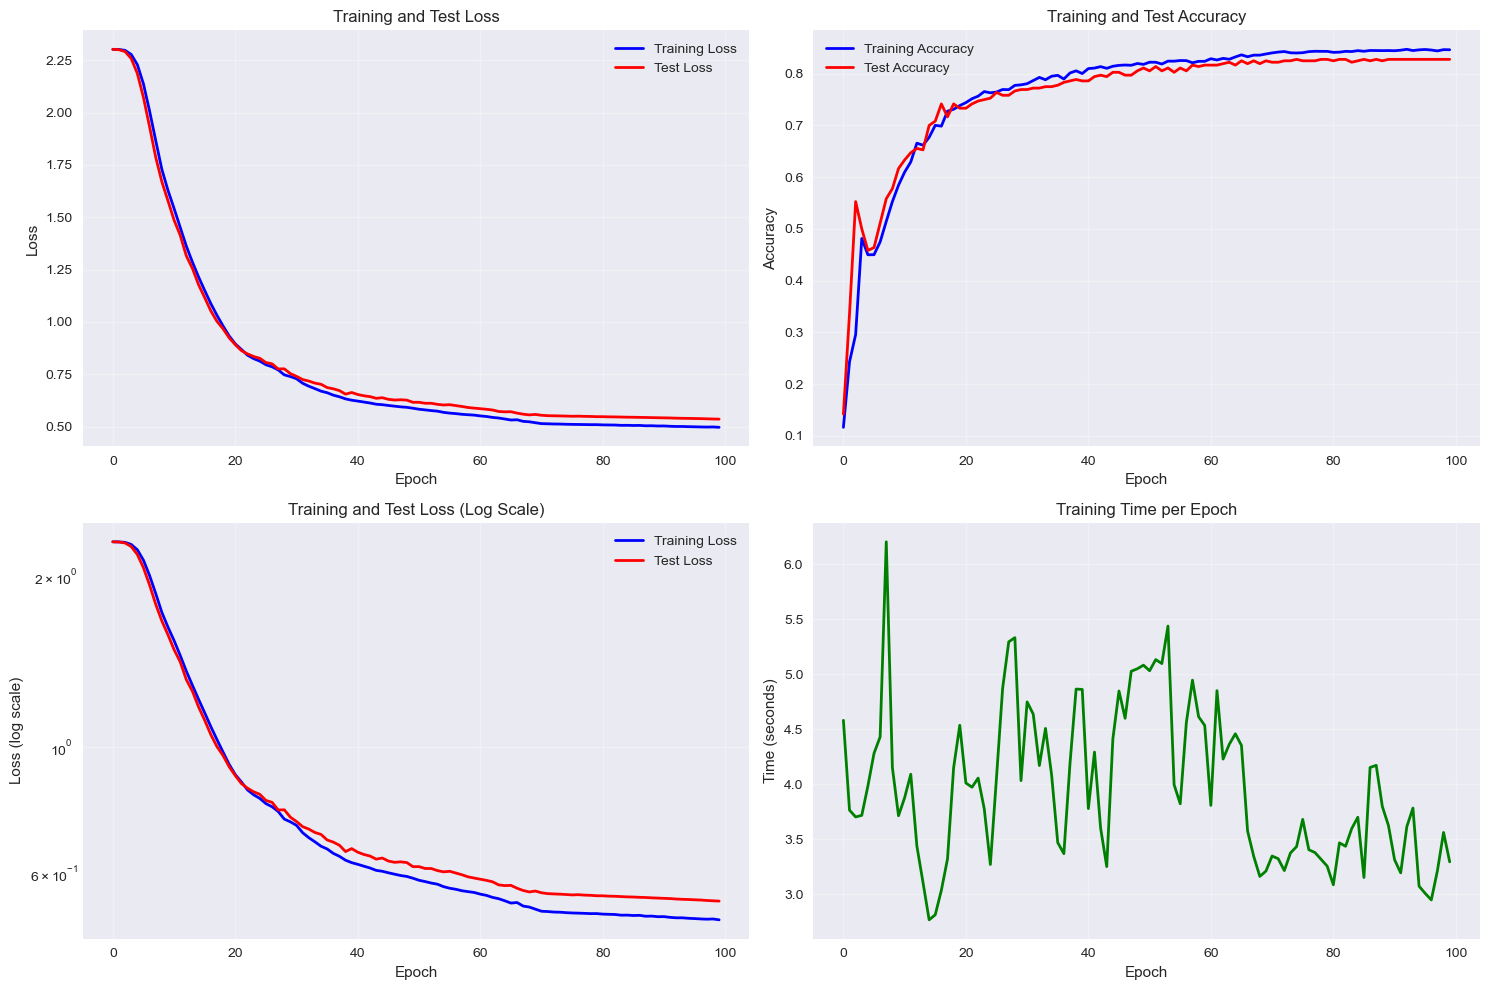


Training Summary:
  Initial train accuracy: 0.1163
  Final train accuracy: 0.8464
  Initial test accuracy: 0.1417
  Final test accuracy: 0.8278
  Best test accuracy: 0.8278 (epoch 74)
  Final train loss: 0.4964
  Final test loss: 0.5356


In [10]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plots
axes[0, 0].plot(train_losses, label='Training Loss', linewidth=2, color='blue')
axes[0, 0].plot(test_losses, label='Test Loss', linewidth=2, color='red')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plots
axes[0, 1].plot(train_accuracies, label='Training Accuracy', linewidth=2, color='blue')
axes[0, 1].plot(test_accuracies, label='Test Accuracy', linewidth=2, color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Test Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Loss on log scale
axes[1, 0].semilogy(train_losses, label='Training Loss', linewidth=2, color='blue')
axes[1, 0].semilogy(test_losses, label='Test Loss', linewidth=2, color='red')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss (log scale)')
axes[1, 0].set_title('Training and Test Loss (Log Scale)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Training time per epoch
axes[1, 1].plot(epoch_times, linewidth=2, color='green')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Time (seconds)')
axes[1, 1].set_title('Training Time per Epoch')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTraining Summary:")
print(f"  Initial train accuracy: {train_accuracies[0]:.4f}")
print(f"  Final train accuracy: {train_accuracies[-1]:.4f}")
print(f"  Initial test accuracy: {test_accuracies[0]:.4f}")
print(f"  Final test accuracy: {test_accuracies[-1]:.4f}")
print(f"  Best test accuracy: {max(test_accuracies):.4f} (epoch {np.argmax(test_accuracies)})")
print(f"  Final train loss: {train_losses[-1]:.4f}")
print(f"  Final test loss: {test_losses[-1]:.4f}")

## 6. Model Evaluation and Metrics

In [11]:
# Final evaluation on test set
model.eval()
test_predictions = model(X_test_tensor)

# Convert to numpy for sklearn metrics
test_pred_np = convert_to_numpy(test_predictions.data)
test_true_np = convert_to_numpy(y_test_tensor.data)

# Get class predictions
test_pred_classes = np.argmax(test_pred_np, axis=1)
test_true_classes = np.argmax(test_true_np, axis=1)

# Calculate final metrics
final_accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f"Final Test Results:")
print(f"  Accuracy: {final_accuracy:.4f}")
print(f"  Total test samples: {len(test_true_classes)}")
print(f"  Correct predictions: {np.sum(test_pred_classes == test_true_classes)}")
print(f"  Incorrect predictions: {np.sum(test_pred_classes != test_true_classes)}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_true_classes, test_pred_classes, 
                          target_names=[f'Digit {i}' for i in range(10)]))

Final Test Results:
  Accuracy: 0.8278
  Total test samples: 360
  Correct predictions: 298
  Incorrect predictions: 62

Classification Report:
              precision    recall  f1-score   support

     Digit 0       0.88      0.97      0.92        36
     Digit 1       0.68      0.64      0.66        36
     Digit 2       0.87      0.97      0.92        35
     Digit 3       0.89      0.92      0.91        37
     Digit 4       0.86      0.89      0.88        36
     Digit 5       0.76      0.70      0.73        37
     Digit 6       0.85      0.97      0.91        36
     Digit 7       0.88      0.83      0.86        36
     Digit 8       0.88      0.66      0.75        35
     Digit 9       0.70      0.72      0.71        36

    accuracy                           0.83       360
   macro avg       0.83      0.83      0.82       360
weighted avg       0.83      0.83      0.82       360



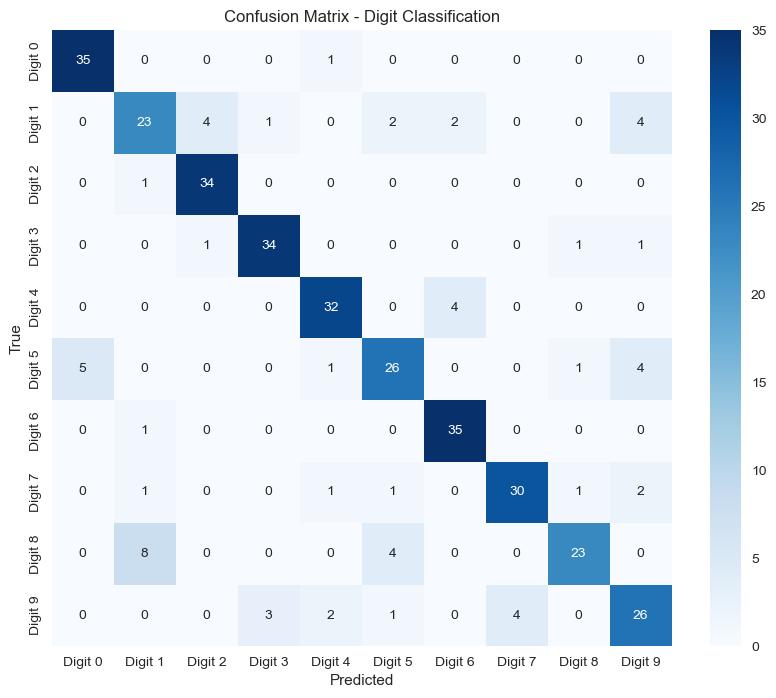


Per-class accuracy:
  Digit 0: 0.9722 (35/36)
  Digit 1: 0.6389 (23/36)
  Digit 2: 0.9714 (34/35)
  Digit 3: 0.9189 (34/37)
  Digit 4: 0.8889 (32/36)
  Digit 5: 0.7027 (26/37)
  Digit 6: 0.9722 (35/36)
  Digit 7: 0.8333 (30/36)
  Digit 8: 0.6571 (23/35)
  Digit 9: 0.7222 (26/36)

Average per-class accuracy: 0.8278


In [12]:
# Confusion Matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Digit {i}' for i in range(10)],
            yticklabels=[f'Digit {i}' for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Digit Classification')
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-class accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"  Digit {i}: {acc:.4f} ({cm.diagonal()[i]}/{cm.sum(axis=1)[i]})")

print(f"\nAverage per-class accuracy: {np.mean(per_class_acc):.4f}")

## 7. Prediction Visualization

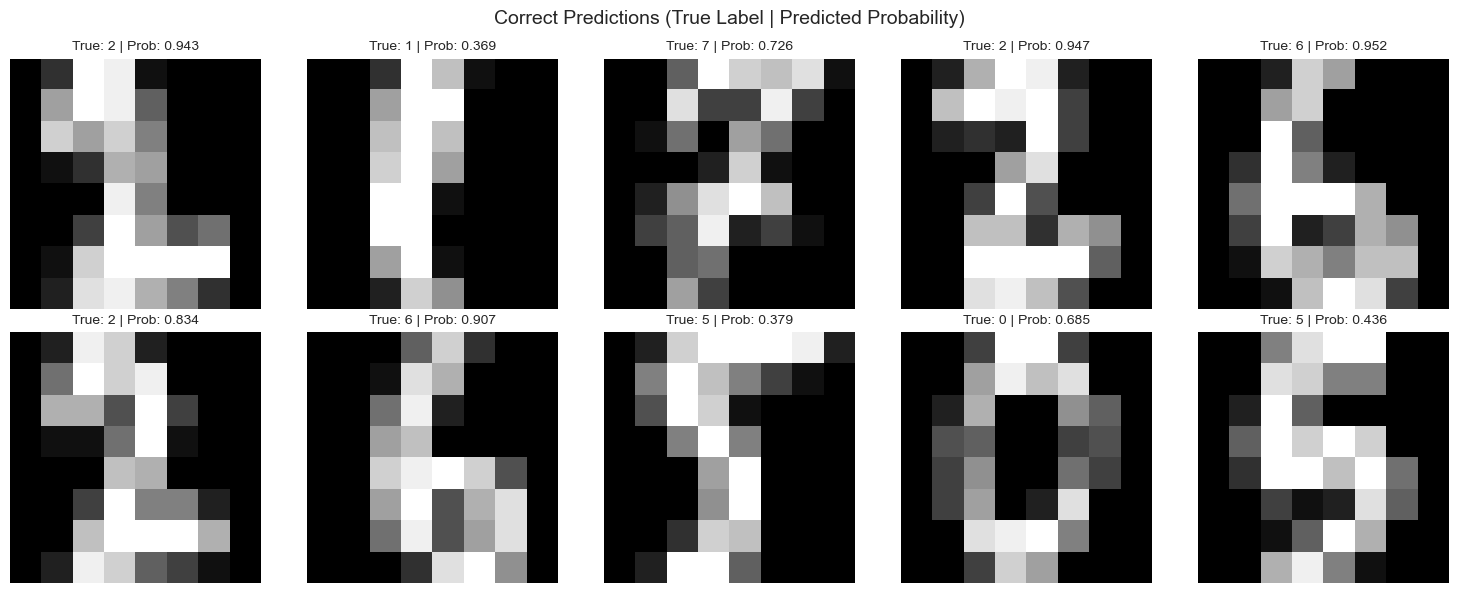

In [13]:
# Visualize correct predictions
correct_mask = test_pred_classes == test_true_classes
correct_indices = np.where(correct_mask)[0]

# Show some correct predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Correct Predictions (True Label | Predicted Probability)', fontsize=14)

for i in range(10):
    if i < len(correct_indices):
        idx = correct_indices[i]
        ax = axes[i // 5, i % 5]
        
        # Show image - convert from NCHW to HW for display
        image = X_test[idx, 0, :, :]  # Take channel 0, get H×W
        ax.imshow(image, cmap='gray')
        
        # Get prediction info
        true_label = test_true_classes[idx]
        pred_prob = test_pred_np[idx, true_label]
        
        ax.set_title(f'True: {true_label} | Prob: {pred_prob:.3f}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

Found 62 incorrect predictions


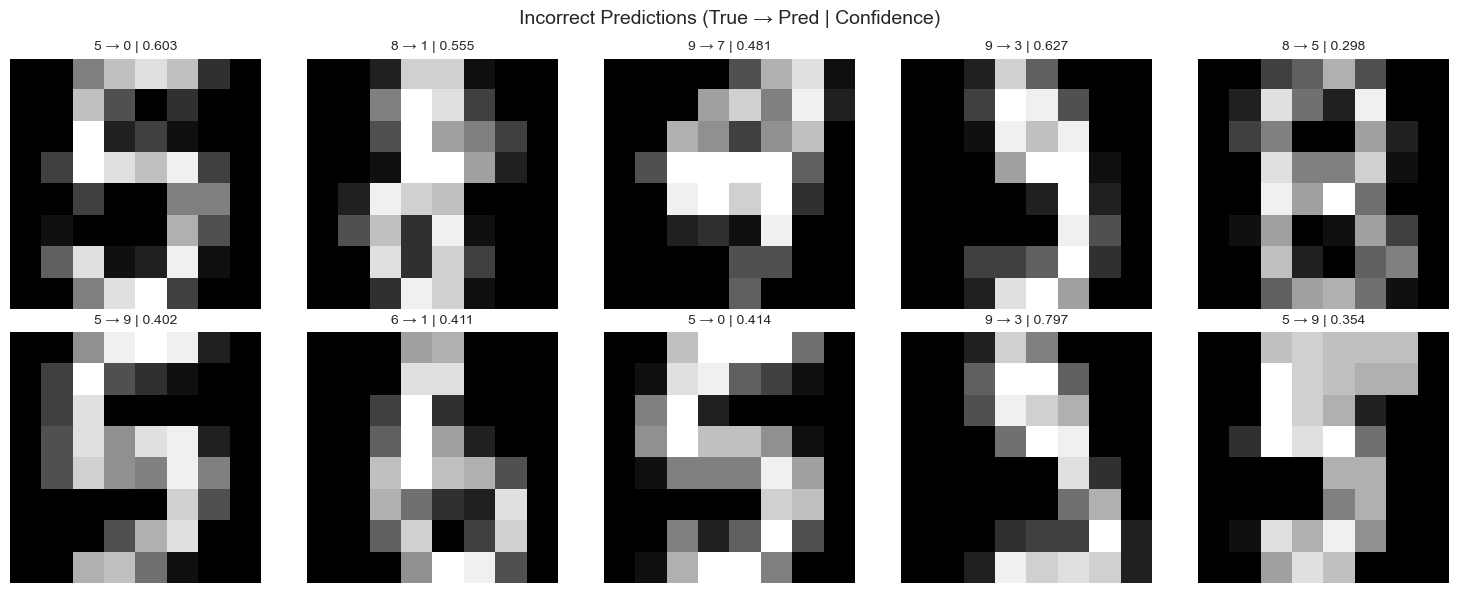

In [14]:
# Visualize incorrect predictions
incorrect_mask = test_pred_classes != test_true_classes
incorrect_indices = np.where(incorrect_mask)[0]

if len(incorrect_indices) > 0:
    print(f"Found {len(incorrect_indices)} incorrect predictions")
    
    # Show some incorrect predictions
    n_show = min(10, len(incorrect_indices))
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle('Incorrect Predictions (True → Pred | Confidence)', fontsize=14)
    
    for i in range(n_show):
        idx = incorrect_indices[i]
        ax = axes[i // 5, i % 5]
        
        # Show image - convert from NCHW to HW for display
        image = X_test[idx, 0, :, :]  # Take channel 0, get H×W
        ax.imshow(image, cmap='gray')
        
        # Get prediction info
        true_label = test_true_classes[idx]
        pred_label = test_pred_classes[idx]
        pred_confidence = test_pred_np[idx, pred_label]
        
        ax.set_title(f'{true_label} → {pred_label} | {pred_confidence:.3f}', fontsize=10)
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(n_show, 10):
        axes[i // 5, i % 5].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Perfect classification! No incorrect predictions found.")

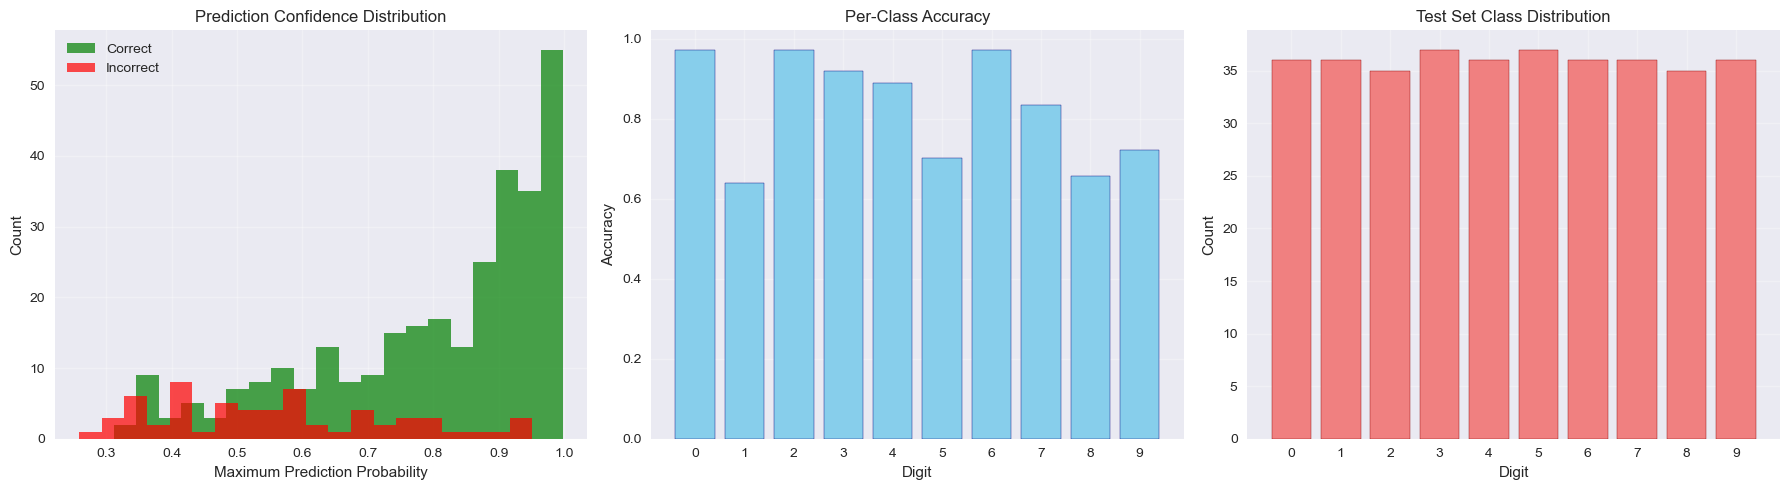


Confidence Statistics:
  Average confidence (correct): 0.8009
  Average confidence (incorrect): 0.5601
  Overall average confidence: 0.7595


In [15]:
# Prediction confidence analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Max prediction probabilities
max_probs = np.max(test_pred_np, axis=1)
correct_probs = max_probs[correct_mask]
incorrect_probs = max_probs[incorrect_mask] if np.any(incorrect_mask) else []

axes[0].hist(correct_probs, bins=20, alpha=0.7, label='Correct', color='green')
if len(incorrect_probs) > 0:
    axes[0].hist(incorrect_probs, bins=20, alpha=0.7, label='Incorrect', color='red')
axes[0].set_xlabel('Maximum Prediction Probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Prediction Confidence Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Per-class accuracy bar plot
axes[1].bar(range(10), per_class_acc, color='skyblue', edgecolor='navy')
axes[1].set_xlabel('Digit')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Per-Class Accuracy')
axes[1].set_xticks(range(10))
axes[1].grid(True, alpha=0.3)

# Class distribution in test set
test_class_counts = np.bincount(test_true_classes)
axes[2].bar(range(10), test_class_counts, color='lightcoral', edgecolor='darkred')
axes[2].set_xlabel('Digit')
axes[2].set_ylabel('Count')
axes[2].set_title('Test Set Class Distribution')
axes[2].set_xticks(range(10))
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nConfidence Statistics:")
print(f"  Average confidence (correct): {np.mean(correct_probs):.4f}")
if len(incorrect_probs) > 0:
    print(f"  Average confidence (incorrect): {np.mean(incorrect_probs):.4f}")
print(f"  Overall average confidence: {np.mean(max_probs):.4f}")

## 8. Feature Visualization (Conv2D Filters)

Visualizing learned Conv2D filters...
First Conv2D layer kernels shape: (32, 1, 3, 3)


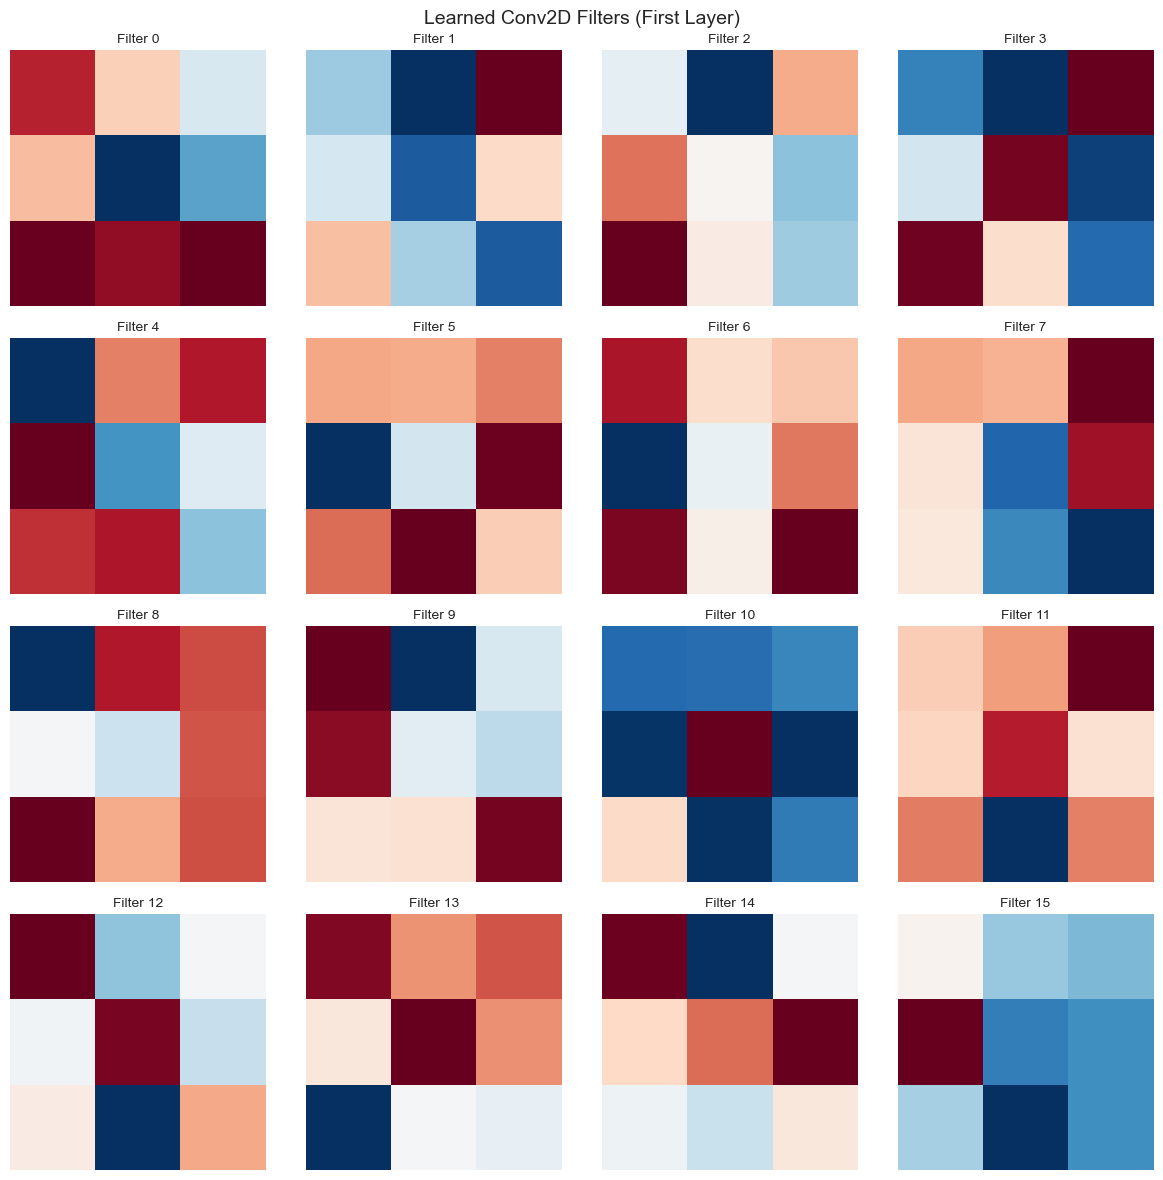

Filter statistics:
  Min value: -0.0427
  Max value: 0.0691
  Mean value: 0.0051
  Std value: 0.0185


In [16]:
# Visualize learned Conv2D filters
print("Visualizing learned Conv2D filters...")

# Get the first Conv2D layer's weights
first_conv_layer = None
for i, module in enumerate(model._modules.values()):
    if hasattr(module, '__class__') and module.__class__.__name__ == 'Conv2D':
        first_conv_layer = module
        break

if first_conv_layer is not None:
    # Get kernels (filters): shape should be (out_channels, in_channels, kernel_h, kernel_w) for NCHW
    kernels = convert_to_numpy(first_conv_layer.kernels.data)
    print(f"First Conv2D layer kernels shape: {kernels.shape}")
    
    # Visualize first 16 filters (since we have 16 output channels)
    n_filters = min(16, kernels.shape[0])
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Learned Conv2D Filters (First Layer)', fontsize=14)
    
    for i in range(n_filters):
        ax = axes[i // 4, i % 4]
        # Extract filter: (in_channels, kernel_h, kernel_w) -> squeeze first dim since in_channels=1
        filter_weights = kernels[i, 0, :, :]  # Take first (and only) input channel
        
        # Normalize for visualization
        vmin, vmax = filter_weights.min(), filter_weights.max()
        if vmax > vmin:
            filter_weights = (filter_weights - vmin) / (vmax - vmin)
        
        im = ax.imshow(filter_weights, cmap='RdBu', vmin=0, vmax=1)
        ax.set_title(f'Filter {i}', fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Filter statistics:")
    print(f"  Min value: {kernels.min():.4f}")
    print(f"  Max value: {kernels.max():.4f}")
    print(f"  Mean value: {kernels.mean():.4f}")
    print(f"  Std value: {kernels.std():.4f}")
else:
    print("No Conv2D layer found in the model.")

## 9. Model Performance Summary

In [17]:
# Comprehensive performance summary
print("=" * 80)
print("               CONV2D NEURAL NETWORK TRAINING SUMMARY")
print("=" * 80)

print(f"\nDataset Information:")
print(f"  Dataset: Sklearn Digits (8x8 handwritten digits)")
print(f"  Total samples: {len(X)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Classes: 10 (digits 0-9)")
print(f"  Input format: NCHW (channels first)")
print(f"  Input shape: {X_train.shape[1:]} (channels, height, width)")

print(f"\nModel Architecture:")
print(f"  Type: Convolutional Neural Network")
print(f"  Conv layers: 2 (1→16→32 channels)")
print(f"  Pooling layers: 2 (MaxPool2D)")
print(f"  Fully connected layers: 2 (128→64→10)")
print(f"  Total parameters: {total_params:,}")
print(f"  Activation functions: ReLU, Softmax")

print(f"\nTraining Configuration:")
print(f"  Optimizer: {optimizer.__class__.__name__}")
print(f"  Learning rate: {learning_rate}")
print(f"  Loss function: {loss_fn.__class__.__name__}")
print(f"  Batch size: {batch_size}")
print(f"  Epochs: {epochs}")
print(f"  Total training time: {total_time:.2f} seconds")

print(f"\nPerformance Results:")
print(f"  Final training accuracy: {train_accuracies[-1]:.4f}")
print(f"  Final test accuracy: {test_accuracies[-1]:.4f}")
print(f"  Best test accuracy: {max(test_accuracies):.4f} (epoch {np.argmax(test_accuracies)})")
print(f"  Final training loss: {train_losses[-1]:.4f}")
print(f"  Final test loss: {test_losses[-1]:.4f}")
print(f"  Correct predictions: {np.sum(test_pred_classes == test_true_classes)}/{len(test_true_classes)}")

print(f"\nFramework Features Demonstrated:")
print(f"  ✓ Conv2D layers with NCHW format")
print(f"  ✓ MaxPool2D for spatial downsampling")
print(f"  ✓ Sequential model building")
print(f"  ✓ Adam optimizer with automatic differentiation")
print(f"  ✓ Categorical cross-entropy loss")
print(f"  ✓ Real dataset (sklearn digits)")
print(f"  ✓ Training loop with batch processing")
print(f"  ✓ Model evaluation and metrics")
print(f"  ✓ Prediction visualization")
print(f"  ✓ Filter visualization")
print(f"  ✓ Comprehensive performance analysis")

print(f"\nDevice Information:")
print(f"  Device: {ng.DEVICE}")
print(f"  Backend: {'CuPy (GPU acceleration)' if ng.DEVICE == 'cuda' else 'NumPy (CPU)'}")

print("=" * 80)
print("Training completed successfully!")
print("=" * 80)

               CONV2D NEURAL NETWORK TRAINING SUMMARY

Dataset Information:
  Dataset: Sklearn Digits (8x8 handwritten digits)
  Total samples: 1797
  Training samples: 1437
  Test samples: 360
  Classes: 10 (digits 0-9)
  Input format: NCHW (channels first)
  Input shape: (1, 8, 8) (channels, height, width)

Model Architecture:
  Type: Convolutional Neural Network
  Conv layers: 2 (1→16→32 channels)
  Pooling layers: 2 (MaxPool2D)
  Fully connected layers: 2 (128→64→10)
  Total parameters: 53,002
  Activation functions: ReLU, Softmax

Training Configuration:
  Optimizer: Adam
  Learning rate: 1e-05
  Loss function: CategoricalCrossEntropy
  Batch size: 16
  Epochs: 100
  Total training time: 396.87 seconds

Performance Results:
  Final training accuracy: 0.8464
  Final test accuracy: 0.8278
  Best test accuracy: 0.8278 (epoch 74)
  Final training loss: 0.4964
  Final test loss: 0.5356
  Correct predictions: 298/360

Framework Features Demonstrated:
  ✓ Conv2D layers with NCHW format
 